Goal: "Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs."

In [123]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

**Importing dataset**

In [98]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [99]:
df.shape

(7043, 21)

**Exploratory Data Analysis**

In [100]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Handle duplicates

In [101]:
df.duplicated().sum()

0

In [102]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [103]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [105]:
numeric_columns = df.select_dtypes('int64', 'float64').columns
numeric_columns

Index(['SeniorCitizen', 'tenure'], dtype='object')

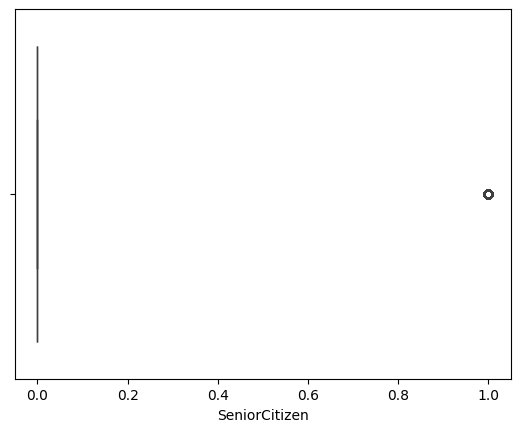

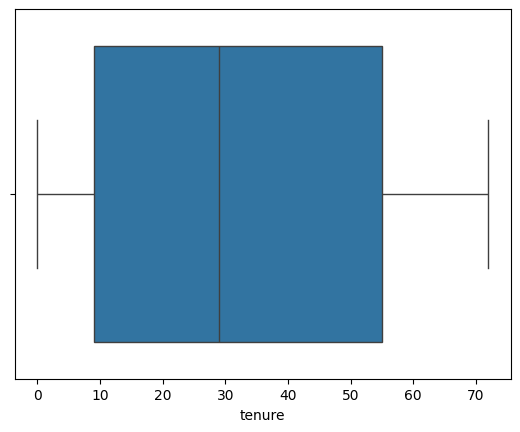

In [106]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

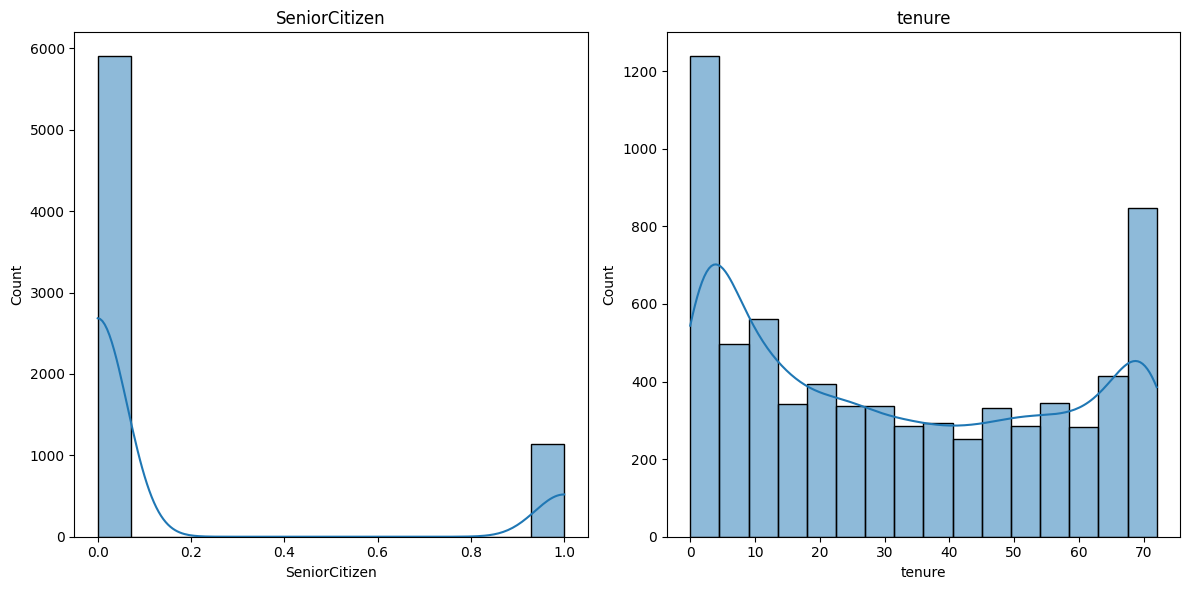

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns

for i, column in enumerate(numeric_columns[:2]):  # Limit to 2 columns for now
    ax = axs[i]  # Directly access each axis for plotting
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [108]:
df.drop('customerID', axis=1, inplace=True)

categorical_columns = df.select_dtypes('object').columns

for col in categorical_columns:
    print(col, ":", df[col].unique())

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


In [109]:
churn_counts = df['Churn'].value_counts(normalize=True)*100
churn_counts

,proportion
Churn,
No,73.463013
Yes,26.536987


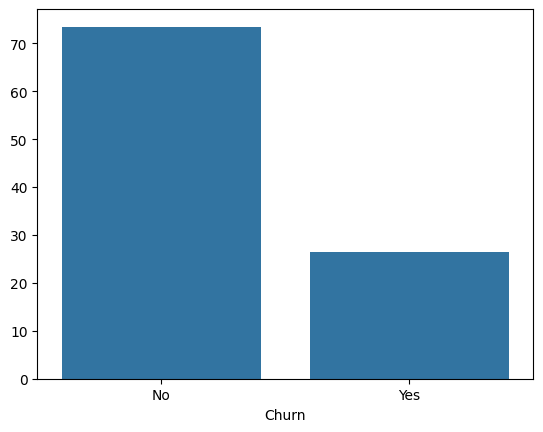

In [110]:
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.show()

In [111]:
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


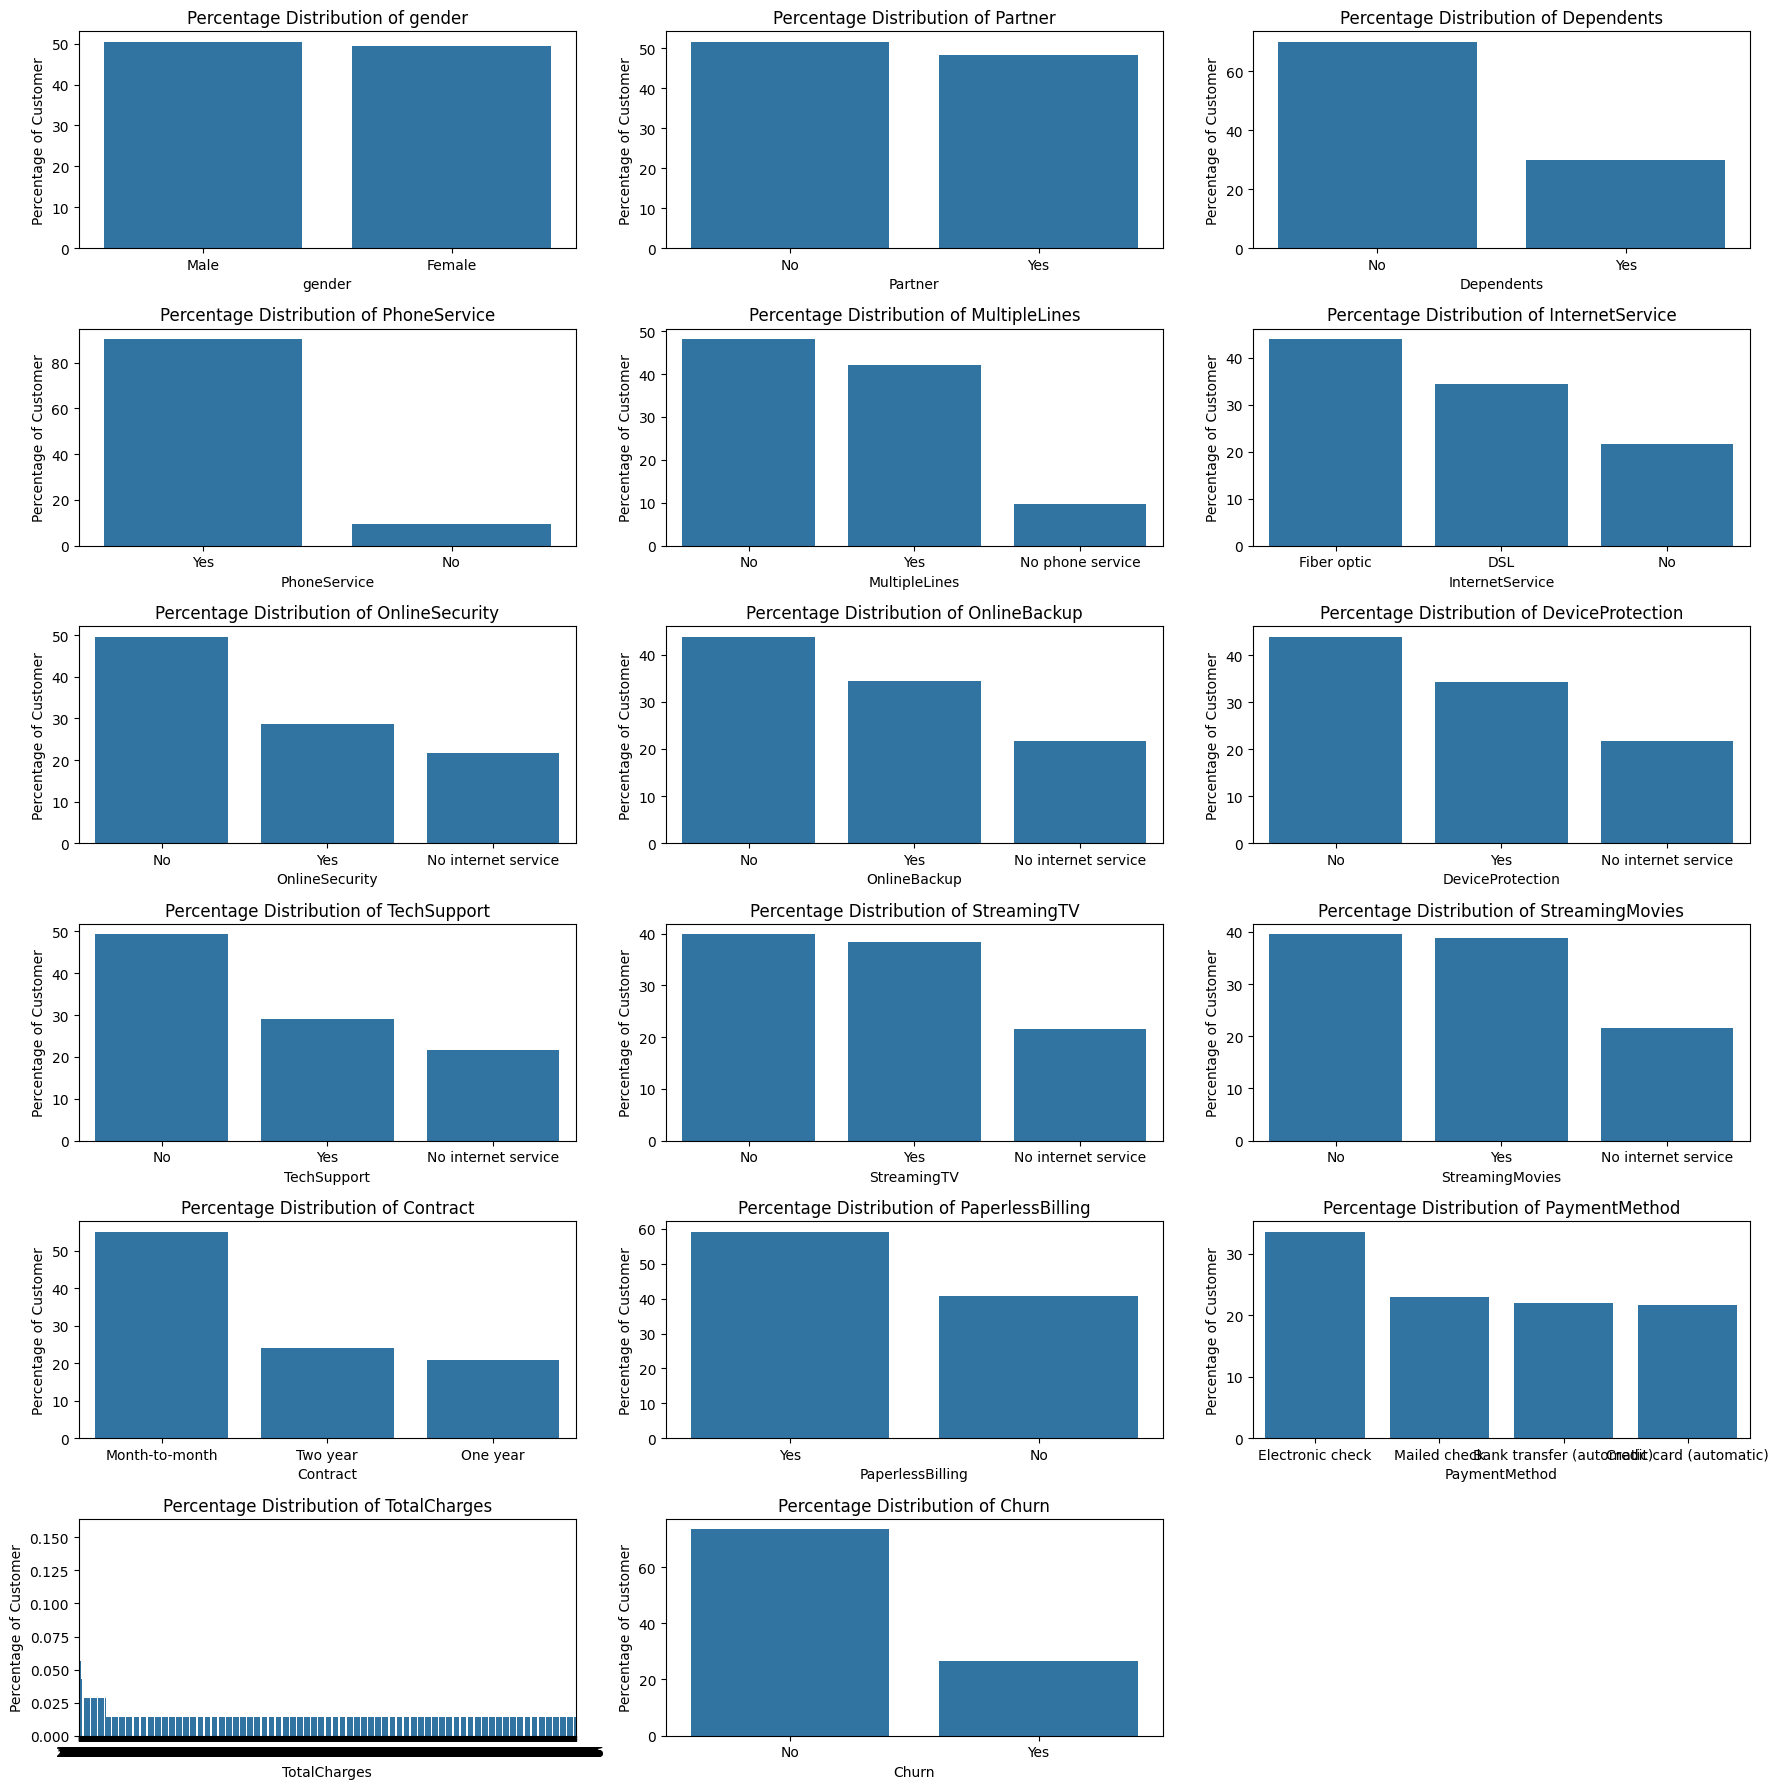

In [112]:
fig, axes = plt.subplots(6, 3, figsize=(18, 18))  # 5 rows, 4 columns
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

# Limit to the first 17 categorical columns
for i, (ax, column) in enumerate(zip(axes, categorical_columns[:17])):
    # Calculate the percentage distribution of each category
    category_counts = df[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Customer')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

# Hide the last 3 axes (for the extra empty subplots)
for ax in axes[17:]:
    ax.set_visible(False)

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

In [114]:
# Convert 'Churn' to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [115]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


In [116]:
# Apply Label Encoding to categorical columns
le = LabelEncoder()
for col in categorical_columns:
    if col != 'customerID':  # Exclude customerID from encoding
        df[col] = le.fit_transform(df[col])

df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1


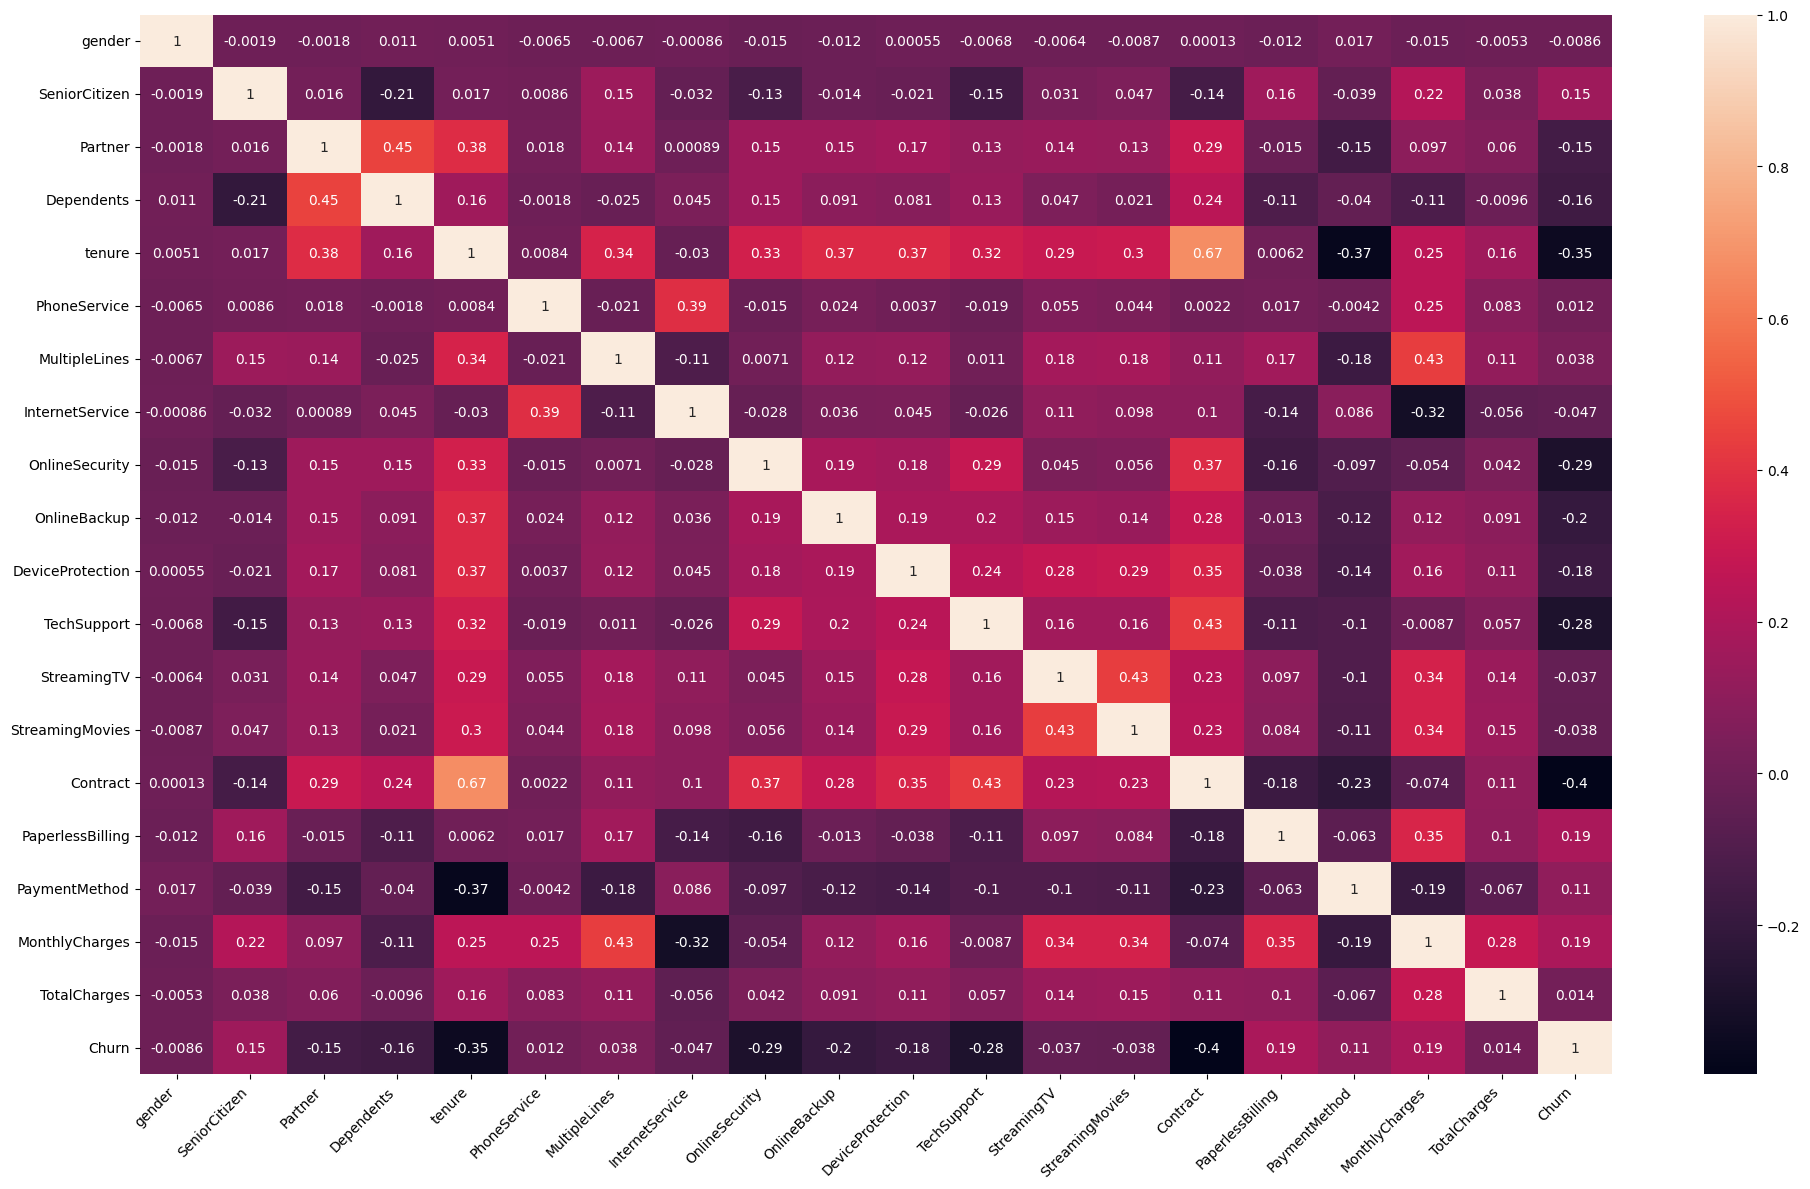

In [117]:
cm = df.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [152]:
from sklearn.preprocessing import MinMaxScaler
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scaling the numerical features
cols_to_scale = ['tenure','MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,0.449599,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,0.462803,0.498896
std,0.500013,0.368612,0.499748,0.458110,0.341104,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,0.299403,0.289233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.125000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.171642,0.246401
50%,1.000000,0.000000,0.000000,0.000000,0.402778,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.518408,0.497550
75%,1.000000,0.000000,1.000000,1.000000,0.763889,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.712438,0.750613
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000


In [153]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [154]:
calculate_vif(X)

,Column,VIF
0,gender,1.929993
1,SeniorCitizen,1.361149
2,Partner,2.818974
3,Dependents,1.958570
4,tenure,7.428930
5,PhoneService,12.581311
6,MultipleLines,2.717725
7,InternetService,4.384073
8,OnlineSecurity,2.256939
9,OnlineBackup,2.431497


In [155]:
calculate_vif(X.drop('PhoneService', axis='columns'))

,Column,VIF
0,gender,1.899253
1,SeniorCitizen,1.360540
2,Partner,2.816226
3,Dependents,1.947245
4,tenure,7.424736
5,MultipleLines,2.671571
6,InternetService,2.536279
7,OnlineSecurity,2.227202
8,OnlineBackup,2.431457
9,DeviceProtection,2.613745


In [156]:
X_reduced = X.drop('PhoneService', axis='columns')

Model Training

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (5634, 18)
x test:  (1409, 18)
y train:  (5634,)
y test:  (1409,)


Logistic Regresssion

In [158]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.2575746727796383, 0.288242536932072)

In [147]:
# Predictions
y_pred = model_lr.predict()

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.49      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

[[946  90]
 [192 181]]


In [162]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([-0.009611,  0.050545,  0.007516, -0.026639, -0.327683,  0.019997,
        0.017929, -0.052358, -0.031101, -0.018342, -0.04811 ,  0.001248,
        0.009704, -0.049354,  0.055475,  0.006153,  0.296465,  0.021511])

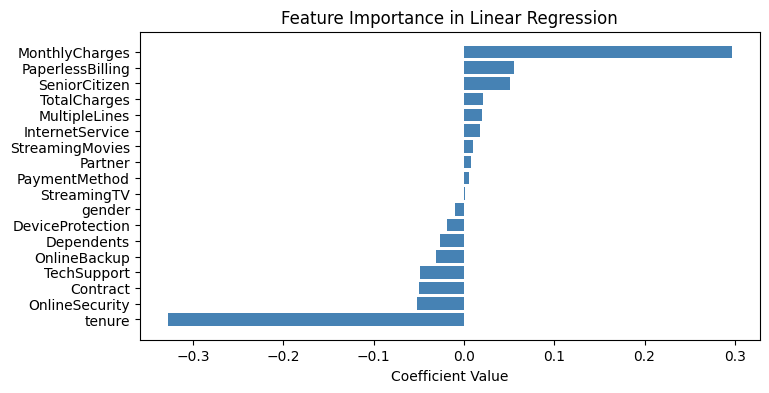

In [163]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [150]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Predictions
y_pred = model_rf.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ValueError: X has 19 features, but RandomForestClassifier is expecting 18 features as input.

In [128]:
importance = model_rf.feature_importances_

# Keep most important features
important_features = X.columns[importance > 0.01]
X_check = X[important_features]

In [130]:
X_check.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,1,0,0,2,0,0,0,0,0,1,2,29.85,2505
1,1,0,0,0,34,0,0,2,0,2,0,0,0,1,0,3,56.95,1466
2,1,0,0,0,2,0,0,2,2,0,0,0,0,0,1,3,53.85,157
3,1,0,0,0,45,1,0,2,0,2,2,0,0,1,0,0,42.30,1400
4,0,0,0,0,2,0,1,0,0,0,0,0,0,0,1,2,70.70,925


In [131]:
X_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   MultipleLines     7043 non-null   int64  
 6   InternetService   7043 non-null   int64  
 7   OnlineSecurity    7043 non-null   int64  
 8   OnlineBackup      7043 non-null   int64  
 9   DeviceProtection  7043 non-null   int64  
 10  TechSupport       7043 non-null   int64  
 11  StreamingTV       7043 non-null   int64  
 12  StreamingMovies   7043 non-null   int64  
 13  Contract          7043 non-null   int64  
 14  PaperlessBilling  7043 non-null   int64  
 15  PaymentMethod     7043 non-null   int64  
 16  MonthlyCharges    7043 non-null   float64


In [132]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


Encode Text Columns

In [134]:
calculate_vif(X)

,Column,VIF
0,gender,1.930602
1,SeniorCitizen,1.366680
2,Partner,2.820768
3,Dependents,1.953659
4,tenure,7.476538
5,PhoneService,14.252701
6,MultipleLines,2.753961
7,InternetService,4.327149
8,OnlineSecurity,2.252831
9,OnlineBackup,2.436458


In [ ]:


nominal_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                'Contract','PaperlessBilling','PaymentMethod']

df2 = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)
df2.head(3)

In [ ]:
df.MultipleLines.value_counts()